In [75]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [76]:
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
# TRAVILY_PROJECT = os.getenv("TRAVILY_PROJECT")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")



In [77]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [78]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")

In [79]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--a76562ff-9f4e-4723-97f2-d3c255980d7c-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [80]:

@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [81]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [82]:
tools=[search,multiply]

In [83]:
model_with_tools=llm.bind_tools(tools)

In [84]:

tool_mapping={tool.name: tool for tool in tools}

In [85]:

tool_mapping
     

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001E93B6F2D40>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001E959C4CAF0>)}

In [86]:
response = model_with_tools.invoke("who is a current president of USA?")

In [87]:
response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "current president of USA"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--85291c47-b2ed-42d8-a24a-b4364bb61b4e-0', tool_calls=[{'name': 'search', 'args': {'query': 'current president of USA'}, 'id': '32badad3-1514-4817-85c1-328d6dfb58da', 'type': 'tool_call'}], usage_metadata={'input_tokens': 41, 'output_tokens': 6, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}})

In [88]:


tool_details=response.additional_kwargs.get("function_call")
     

In [89]:
tool_details

{'name': 'search', 'arguments': '{"query": "current president of USA"}'}

In [90]:

tool_details["name"]
     

'search'

In [91]:
tool_details["arguments"]

'{"query": "current president of USA"}'

In [92]:
json.loads(tool_details["arguments"])

{'query': 'current president of USA'}

In [93]:

tool_mapping[tool_details["name"]].invoke(json.loads(tool_details["arguments"]))

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': 'Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\n## President of the United States\n\nThe president of the United States is the:\n\n### Current president\n\nThe 47th and current president of the United States is Donald John Trump. He was sworn into office on January 20, 2025.\n\n### Former U.S. presidents [...] The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n\n### Current vice president\n\nThe 50th and current vice president of the United States is James David (JD) Vance. H

In [104]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [105]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}
     

In [113]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("function_call", [])
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("name")}')
    
    if tool_details.get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['name']].invoke(json.loads(tool_details.get("arguments")))
    return {"messages" : [response]}
     

In [114]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("function_call", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [115]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

In [116]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [117]:
app = graph.compile()

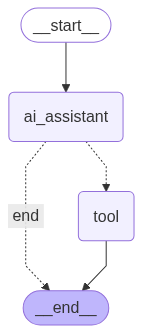

In [118]:


from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [119]:

for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "who is upcoming president of USA?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--c728e982-38b3-4848-bd62-3cab639b79bf-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is upcoming president of USA?'}, 'id': '9f9709ab-cce9-4f4e-ab6f-32084480be70', 'type': 'tool_call'}], usage_metadata={'input_tokens': 40, 'output_tokens': 9, 'total_tokens': 49, 'input_token_details': {'cache_read': 0}})]}
----
Selected tool: search
{'messages': [[{'title': 'United States presidential line of succession', 'url': 'https://en.wikipedia.org/wiki/United_States_presidential_line_of_succession', 'content': 'Current order of succession ; 1, Vice President · JD Vance ; 2, Speaker of the House of Representatives · Mike Johnson ; 3, President pro tempore of the 

In [120]:

for s in app.stream({"messages": ["multiply 3 and 4"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"second_number": 4.0, "first_number": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--2d8baf1a-6db0-4ea1-8d4b-c9414dc8f98a-0', tool_calls=[{'name': 'multiply', 'args': {'second_number': 4.0, 'first_number': 3.0}, 'id': 'ce74ebaf-2258-42ae-bdea-da40015932ca', 'type': 'tool_call'}], usage_metadata={'input_tokens': 39, 'output_tokens': 9, 'total_tokens': 48, 'input_token_details': {'cache_read': 0}})]}
----
Selected tool: multiply
{'messages': [12]}
----


In [122]:

for s in app.stream({"messages": ["can you tell me th etotal money that exist in the world"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='I cannot calculate the total amount of money in the world.  There is no single, universally agreed-upon definition of "money," and even if there were, measuring it would be incredibly complex and constantly changing.  Different forms of money exist (physical cash, bank deposits, investments, etc.), and tracking their movement and value in real-time across the globe is practically impossible.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--7a656dda-fee7-4e35-831c-6fca71027cff-0', usage_metadata={'input_tokens': 46, 'output_tokens': 78, 'total_tokens': 124, 'input_token_details': {'cache_read': 0}})]}
----
